<a href="https://colab.research.google.com/github/Khyojae/2025.LLM/blob/main/dbn_251110.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이터 로드/ 전처리(MNIST)

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
(xtr, ytr), (xte, yte) = tf.keras.datasets.mnist.load_data()
xtr = (xtr.astype("float32")/225.).reshape(-1,784)
xte = (xte.astype("float32")/225.).reshape(-1,784)

#교육용 RBM은 베르누이 가정이므로 약간의 이산화

BATCH =128
trans_ds = tf.data.Dataset.from_tensor_slices(xtr).shuffle(10000).batch(BATCH)

RBM클래스

In [ ]:
import tensorflow as tf
import numpy as np

class RBM(tf.keras.Model):
    def __init__(self, n_visible, n_hidden, k=1):
        super().__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.k = k

        # Xaiver 초기화
        limit = np.sqrt(6. / (n_visible + n_hidden))
        self.W = tf.Variable(tf.random.uniform([n_visible, n_hidden], -limit, limit), name="W")
        self.vb = tf.Variable(tf.zeros([n_visible]), name="vb")
        self.hb = tf.Variable(tf.zeros([n_hidden]), name="hb")

    @staticmethod
    def _sigm(x): return tf.math.sigmoid(x)

    def sample_h(self, v):
        p_h = self._sigm(tf.matmul(v, self.W) + self.hb)
        return p_h, tf.cast(tf.random.uniform(tf.shape(p_h)) < p_h, tf.float32)

    def sample_v(self, h):
        p_v = self._sigm(tf.matmul(h, tf.transpose(self.W)) + self.vb)
        return p_v, tf.cast(tf.random.uniform(tf.shape(p_v)) < p_v, tf.float32)

    # cd_loss_and_grads 메서드 시작
    def cd_loss_and_grads(self, v0):
      with tf.GradientTape() as tape:
        # 깁스 샘플링 과정을 GradientTape에 포함시키지 않습니다.
        # RBM은 Reconstruction Loss의 경사가 아닌, CD 통계량의 차이를 사용합니다.

        p_h0, h0 = self.sample_h(v0)

        # 깁스 체인 시작 (v0에서 시작)
        vk, hk = v0, h0

        for _ in range(self.k):
            # v -> h
            p_vk, vk = self.sample_v(hk)
            # h -> v
            p_hk, hk = self.sample_h(vk)

        # CD-1 loss : 가중치 업데이트에 필요한 통계량만 사용
        # E_data [v0 * p_h0^T]
        pos = tf.matmul(tf.transpose(v0), p_h0)
        # E_recon [vk * p_hk^T]
        neg = tf.matmul(tf.transpose(vk), p_hk)

        # resconstruction cross-entropy (모니터링용)
        # ⚠️ 참고: pvk는 깁스 체인 내에서 계산되는 변수 이름이므로,
        # 만약 vk로 최종 재구성된 확률을 사용하려면 p_vk를 사용해야 합니다.
        recon_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(v0, p_vk)
        )

        # parameter gradients (w,vb,hb)
        dw = (pos - neg) / tf.cast(tf.shape(v0)[0], tf.float32)
        dvb = tf.reduce_mean(v0 - vk, axis=0)
        dhb = tf.reduce_mean(h0 - hk, axis=0)

        return recon_loss, [dw, dvb, dhb]

    # fit_rbm 메서드 시작
    def fit_rbm(self, dataset, epochs=10, lr=1e-3):
        opt = tf.keras.optimizers.Adam(lr)
        losses = [] # ⚠️ 'losses' 변수가 정의되지 않아 추가

        for epoch in range(1,epochs+1):
            epoch_loss = []

            for v0 in dataset:
                # 깁스 샘플링은 경사를 필요로 하지 않으므로 GradientTape 없이 호출
                loss, [dw, dvb, dhb] = self.cd_loss_and_grads(v0)

                # 경사 적용
                opt.apply_gradients([
                    (-dw, self.W),
                    (-dvb, self.vb),
                    (-dhb, self.hb)
                ])
                epoch_loss.append(loss.numpy())

            # ⚠️ 'printf'와 'ep' 대신 표준 Python print와 'epoch' 사용
            print(f"[RBM] epoch {epoch + 1:02d} recon={np.mean(epoch_loss):.4f}")
            losses.extend(epoch_loss)

    # transform 메서드 시작 (특징 추출)
    def transform(self, X, batch=512):
        H = []
        for i in range(0, X.shape[0], batch):
            v = tf.convert_to_tensor(X[i:i + batch], dtype=tf.float32)
            p_h, _ = self.sample_h(v)
            H.append(p_h.numpy())
        return np.concatenate(H, axis=0)

    # generate 메서드 시작 (샘플 생성)
    def generate(self, n=16, steps=200):
        # ⚠️ h와 v 초기화 시, RBM은 이진(0 또는 1) 상태를 사용하거나 확률을 사용할 수 있음.
        # 현재 코드는 이진 상태로 시작하므로 유지
        h = tf.cast(tf.random.uniform([n, self.n_hidden]) < 0.5, tf.float32)
        # v의 초기화는 보통 h에서 시작하는 것이 일반적이지만, 코드 로직대로 유지
        v = tf.cast(tf.random.uniform([n, self.n_visible]) < 0.5, tf.float32) # ⚠️ n_hidden -> n_visible로 수정

        for _ in range(steps):
            # 깁스 샘플링
            pv, v_sampled = self.sample_v(h) # h -> v
            _, h = self.sample_h(v_sampled) # v -> h

        # 마지막 재구성 확률을 반환
        return pv.numpy()

In [ ]:
# 1층 RBM
rbm1= RBM(784,256,k=1)
rbm1.fit_rbm(trans_ds, epochs=10, lr=1e-3) # ✅ 'trans_ds' 사용

# 2층 RBM
H1 = rbm1.transform(xtr)
train_ds_h1 = tf.data.Dataset.from_tensor_slices(H1).shuffle(10000).batch(BATCH)
rbm2 = RBM(256,128,k=1)
rbm2.fit_rbm(train_ds_h1, epochs=10, lr=1e-3)

[RBM] epoch 02 recon=0.2010
[RBM] epoch 03 recon=0.1233
[RBM] epoch 04 recon=0.1019
[RBM] epoch 05 recon=0.0897
[RBM] epoch 06 recon=0.0816
[RBM] epoch 07 recon=0.0756
[RBM] epoch 08 recon=0.0708
[RBM] epoch 09 recon=0.0670
[RBM] epoch 10 recon=0.0637
[RBM] epoch 11 recon=0.0609
[RBM] epoch 02 recon=0.4764
[RBM] epoch 03 recon=0.3645
[RBM] epoch 04 recon=0.3294
[RBM] epoch 05 recon=0.3100
[RBM] epoch 06 recon=0.2969
[RBM] epoch 07 recon=0.2874
[RBM] epoch 08 recon=0.2804
[RBM] epoch 09 recon=0.2749
[RBM] epoch 10 recon=0.2707
[RBM] epoch 11 recon=0.2674


In [ ]:
from tensorflow.keras import layers, models, optimizers
dense1 = layers.Dense(256,activation="sigmoid")
dense2= layers.Dense(128,activation="sigmoid")
dense1.build((None,784))
dense2.build((None,256))
dense1.set_weights([rbm1.W.numpy(),rbm1.hb.numpy()])
dense2.set_weights([rbm2.W.numpy(),rbm2.hb.numpy()])

clf = models.Sequential([
    layers.Input(shape=(784,)),
    dense1,
    dense2,
    layers.Dense(10,activation="softmax")
])

clf.compile(optimizers.Adam(1e-3),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
hist = clf.fit(xtr,ytr,validation_data=(xte,yte),epochs=10, batch_size=128,verbose=1)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.6956 - loss: 1.0750 - val_accuracy: 0.9366 - val_loss: 0.2404
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9414 - loss: 0.2170 - val_accuracy: 0.9547 - val_loss: 0.1621
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9598 - loss: 0.1466 - val_accuracy: 0.9617 - val_loss: 0.1327
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9676 - loss: 0.1132 - val_accuracy: 0.9662 - val_loss: 0.1123
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9765 - loss: 0.0857 - val_accuracy: 0.9695 - val_loss: 0.0985
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9820 - loss: 0.0688 - val_accuracy: 0.9731 - val_loss: 0.0884
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9847 - loss: 0.0575 - val_accuracy: 0.9737 - val_loss: 0.0829
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9876 - loss: 0.0464 - val_accu

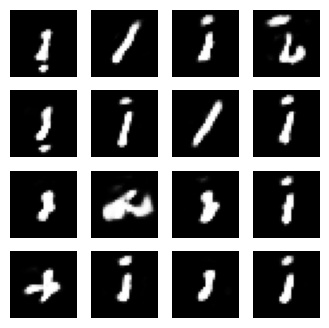

In [ ]:
import matplotlib.pyplot as plt

samples = rbm1.generate(n=16,steps=200)
fig, axs = plt.subplots(4,4,figsize=(4,4))
for i, ax in enumerate(axs.ravel()):
  ax.imshow(samples[i].reshape(28,28), cmap="gray")
  ax.axis("off")
plt.show()